In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
from torchvision.io import read_image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import os
import numpy as np
from tqdm import tqdm

In [4]:
# These numbers are mean and std values for channels of natural images. 
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Inverse transformation: needed for plotting.
unnormalize = transforms.Normalize(
   mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
   std=[1/0.229, 1/0.224, 1/0.225]
)

transform = transforms.Compose([
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ColorJitter(hue=.2, saturation=.2, contrast=.2),
#                                     transforms.RandomRotation(20, interpolation=Image.BILINEAR),
                                    transforms.GaussianBlur(7, sigma=(0.1, 1.0)),
                                    normalize,
                                ])

class SupervisedDataset(Dataset):
    
    def __init__(self,data_dir,transform=transform,num_frames=22):
        self.data_dir = data_dir
        self.transform = transform
        self.num_frames = num_frames
        self.image_list = []
        
        for vid_dir in os.listdir(self.data_dir):
            for i in range(self.num_frames):
                self.image_list.append((self.data_dir+"/"+vid_dir + "/" + "image_"+str(i)+".png",i))
                
    def __len__(self):
        return len(self.image_list)
    
    def __getitem__(self,idx):
        image_path = self.image_list[idx][0]
        image_ind = self.image_list[idx][1]
        
        vid_dir = "/".join(image_path.split("/")[:-1])
        mask_path = vid_dir+"/mask.npy"
        
        img = read_image(image_path)
        img = img/255.0
        
        if self.transform:
            img = self.transform(img)
        
        mask = np.load(mask_path)
        mask = mask[image_ind,:,:]
        
        return img,mask

In [5]:
train_dataset = SupervisedDataset("/dataset/dataset/train")
val_dataset = SupervisedDataset("/dataset/dataset/val")
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=True)

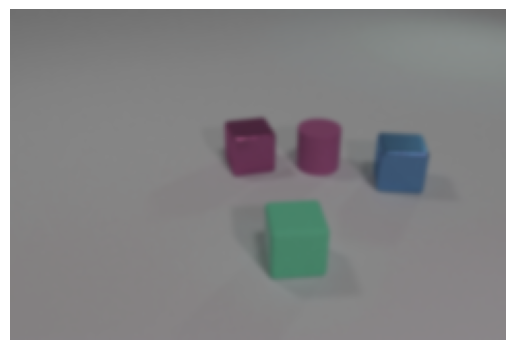

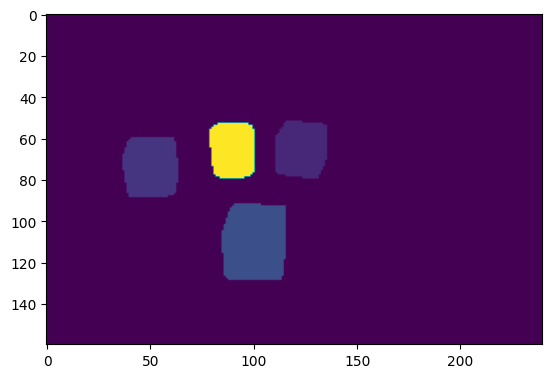

In [6]:
from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 100 # change dpi to make plots bigger

def show_normalized_image(img, title=None):
    plt.imshow(unnormalize(img).detach().cpu().permute(1, 2, 0).numpy())
    plt.title(title)
    plt.axis('off')
    plt.show()
    
ind = 31
show_normalized_image(val_dataset[ind][0])
plt.imshow(val_dataset[ind][1])

In [7]:
!pip install -U segmentation-models-pytorch

Defaulting to user installation because normal site-packages is not writeable


In [8]:
def train(model,epochs,criterion,optimizer):
    model.train()

    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, num_workers=4)
    val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=64, num_workers=4)

    if torch.cuda.is_available():
        model = model.cuda()
        criterion = criterion.cuda()
        device = torch.device("cuda:0")
    else:
        device = torch.device("cpu")

    for e in range(epochs):

        total_train_loss = 0
        total_train_accuracy = 0
        total_val_loss = 0
        total_val_accuracy = 0

        total_train = 0
        total_val = 0

        model.train()
        
        pbar = tqdm(train_dataloader,leave=False)

        for batch in pbar:

            data,target = batch
            data = data.to(device)
            target = target.to(device)
            
            p2d = (8, 8)
            data = torch.nn.functional.pad(data, p2d, "constant", 0)

            output = model(data)
            output = output[:,:,:,8:output.shape[3]-8]
#             output = output.type(torch.LongTensor).to(device)
            target = target.type(torch.LongTensor).to(device)
            
            loss = criterion(output,target)

            optimizer.zero_grad()

            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            

            pbar.set_postfix({'epoch':e,'batch_train_loss': loss.item()})
            
            
        
        mean_train_loss = total_train_loss / len(train_dataset)
        mean_val_loss = total_val_loss / len(val_dataset)


In [9]:
import segmentation_models_pytorch as smp

model = smp.UnetPlusPlus(
    encoder_name="mobilenet_v2",        
    encoder_weights=None,     
    in_channels=3,                  
    classes=49,
    activation='softmax'
)

In [10]:
# criterion = smp.losses.FocalLoss(mode='multiclass', alpha= 0.5, gamma= 2)
criterion = smp.losses.JaccardLoss(mode='multiclass',log_loss=True)
# criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(),
                          lr=1e-5, weight_decay=1e-8, momentum=0.999, foreach=True)
train(model,20,criterion,optimizer)

  0%|          | 0/344 [00:00<?, ?it/s]/home/pt2310/.local/lib/python3.10/site-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


  0%|          | 0/2750 [00:00<?, ?it/s]

torch.Size([1, 3, 160, 240]) torch.Size([160, 240])


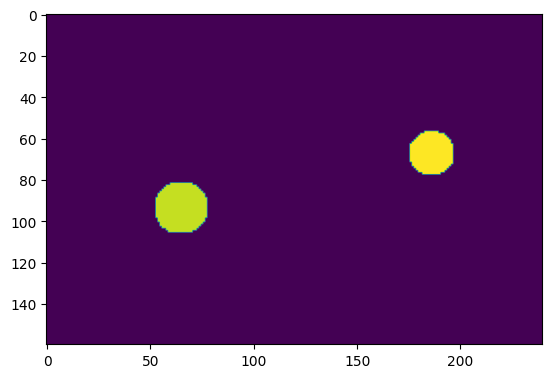

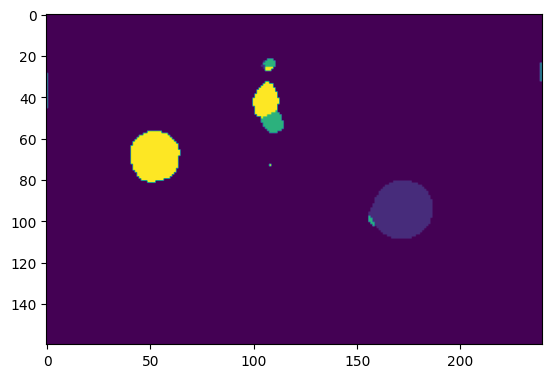

  0%|          | 1/2750 [00:00<18:22,  2.49it/s]

torch.Size([1, 3, 160, 240]) torch.Size([160, 240])


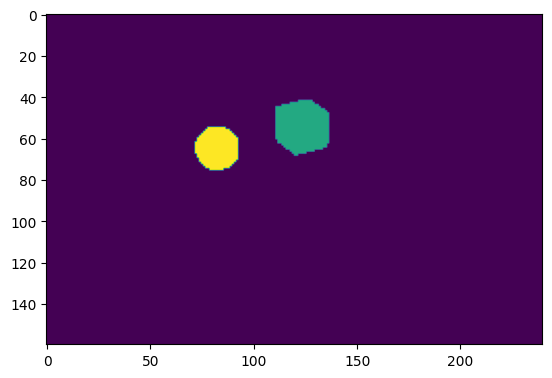

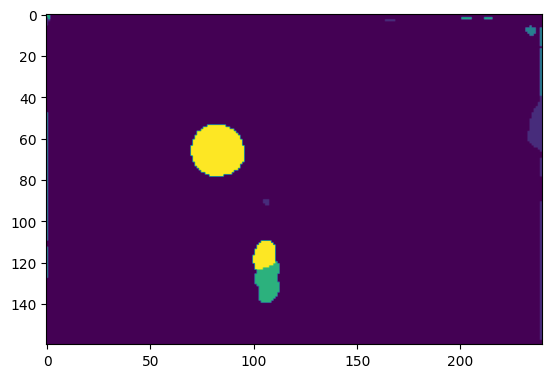

  0%|          | 2/2750 [00:00<17:58,  2.55it/s]

torch.Size([1, 3, 160, 240]) torch.Size([160, 240])


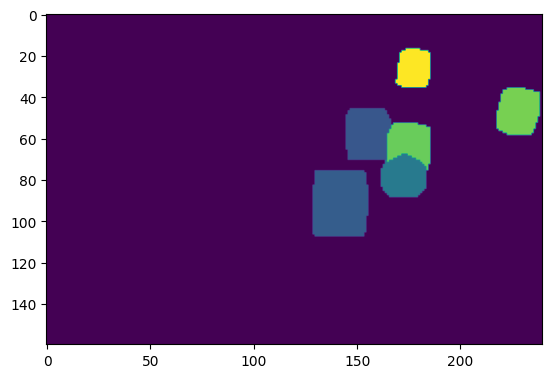

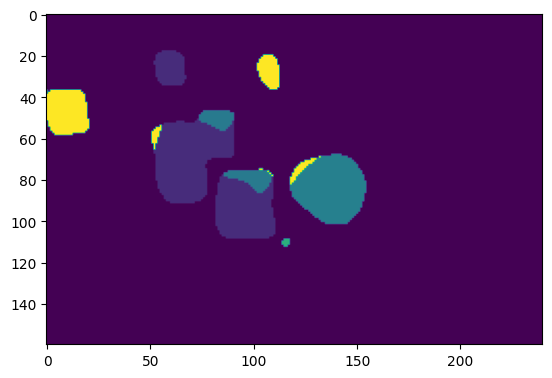

  0%|          | 3/2750 [00:01<18:12,  2.51it/s]

torch.Size([1, 3, 160, 240]) torch.Size([160, 240])


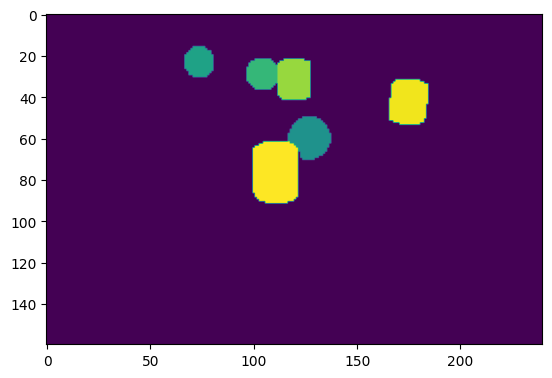

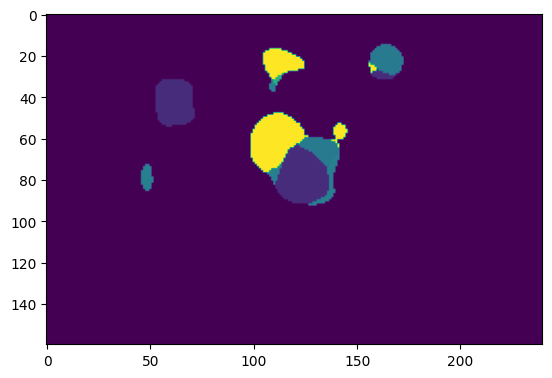

  0%|          | 4/2750 [00:01<18:11,  2.52it/s]

torch.Size([1, 3, 160, 240]) torch.Size([160, 240])


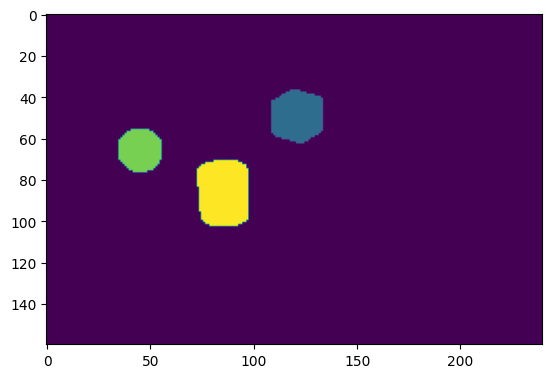

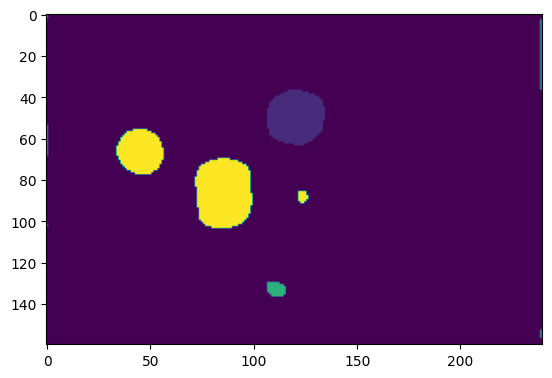

  0%|          | 5/2750 [00:01<18:05,  2.53it/s]

torch.Size([1, 3, 160, 240]) torch.Size([160, 240])


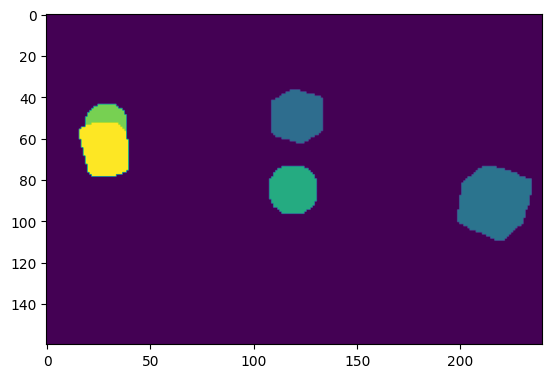

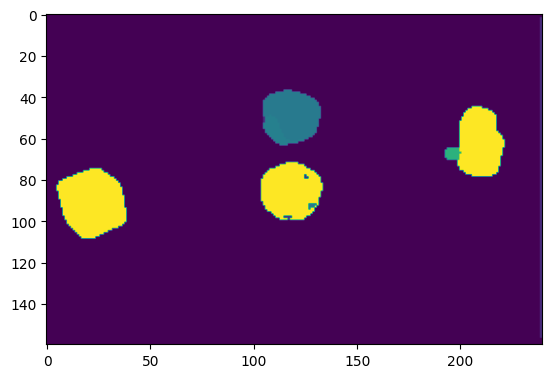

  0%|          | 6/2750 [00:02<18:02,  2.54it/s]

torch.Size([1, 3, 160, 240]) torch.Size([160, 240])


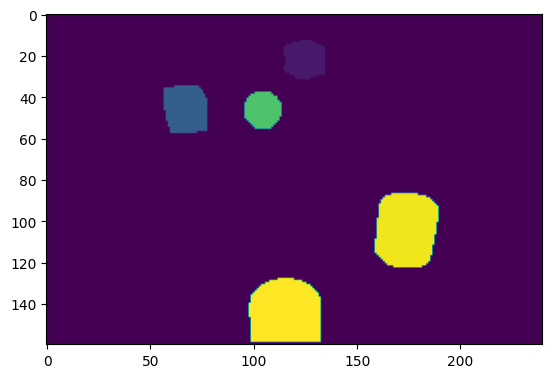

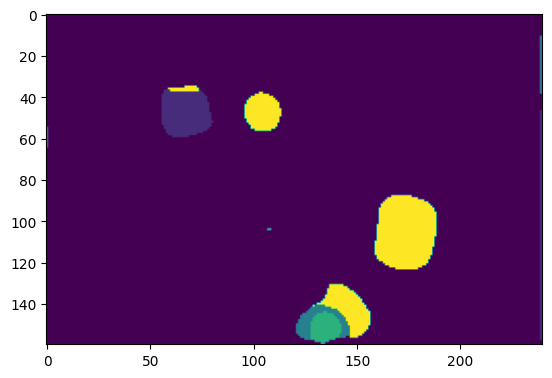

  0%|          | 7/2750 [00:02<17:57,  2.55it/s]

torch.Size([1, 3, 160, 240]) torch.Size([160, 240])


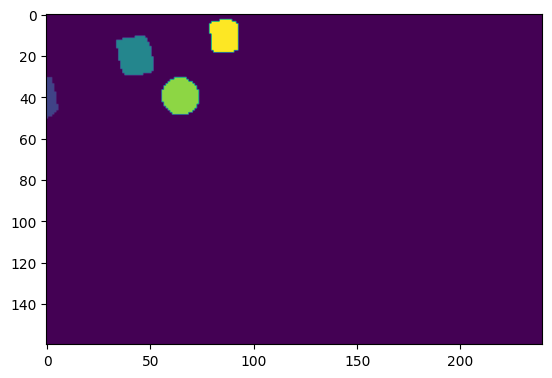

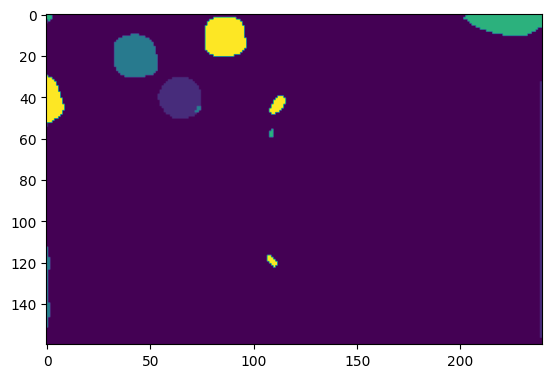

  0%|          | 8/2750 [00:03<17:41,  2.58it/s]

torch.Size([1, 3, 160, 240]) torch.Size([160, 240])


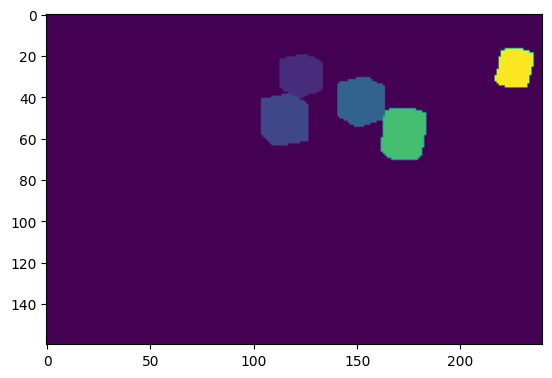

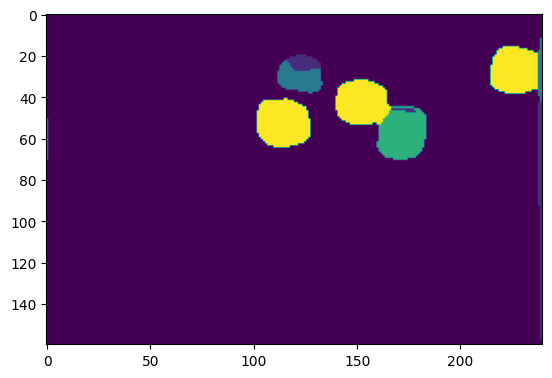

  0%|          | 9/2750 [00:03<17:26,  2.62it/s]

torch.Size([1, 3, 160, 240]) torch.Size([160, 240])


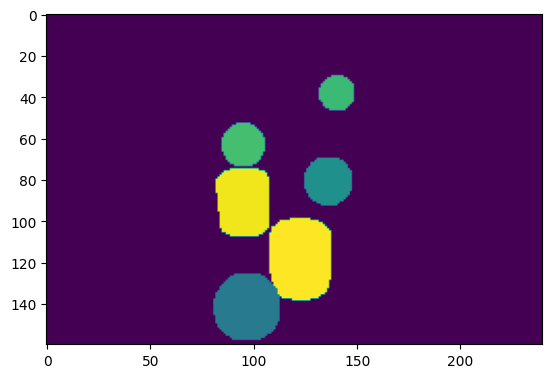

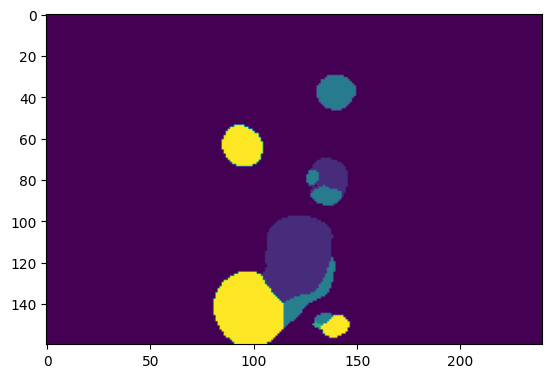

  0%|          | 10/2750 [00:03<17:29,  2.61it/s]

torch.Size([1, 3, 160, 240]) torch.Size([160, 240])


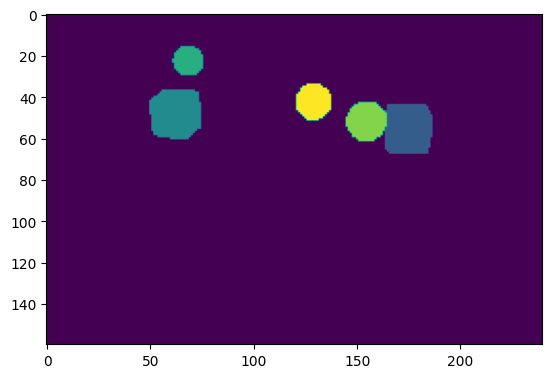

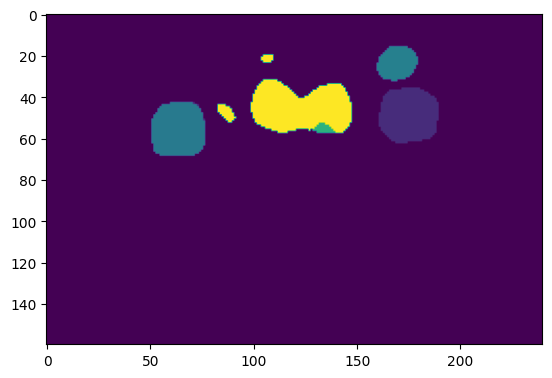

  0%|          | 11/2750 [00:04<17:19,  2.63it/s]

torch.Size([1, 3, 160, 240]) torch.Size([160, 240])


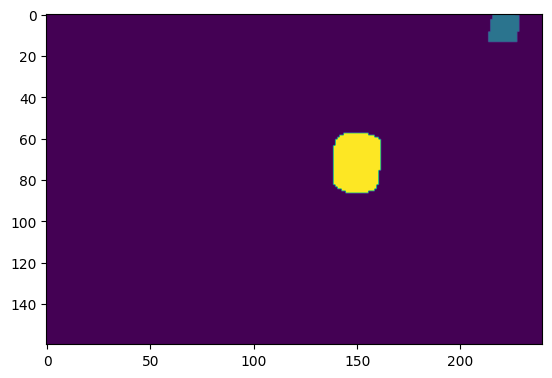

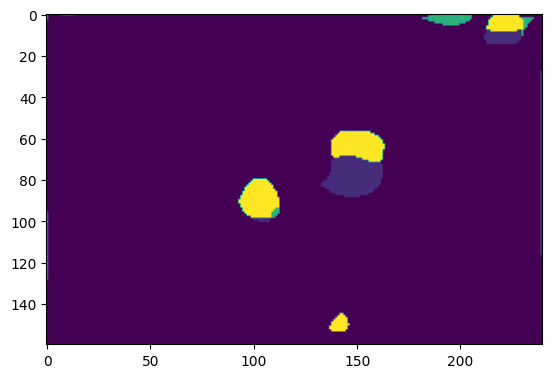

  0%|          | 12/2750 [00:04<17:16,  2.64it/s]

torch.Size([1, 3, 160, 240]) torch.Size([160, 240])


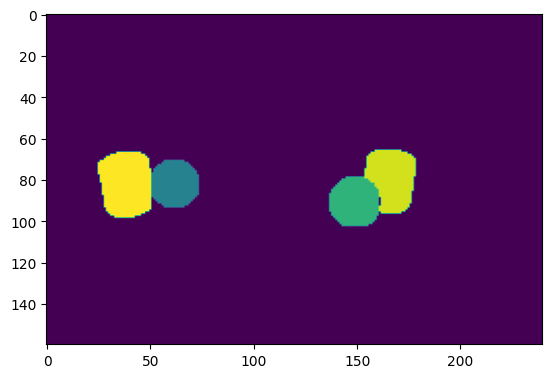

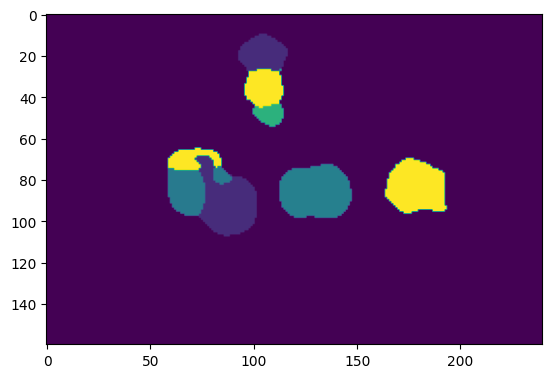

  0%|          | 13/2750 [00:05<17:10,  2.66it/s]

torch.Size([1, 3, 160, 240]) torch.Size([160, 240])


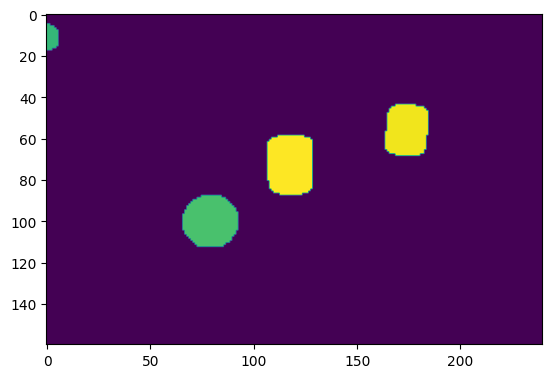

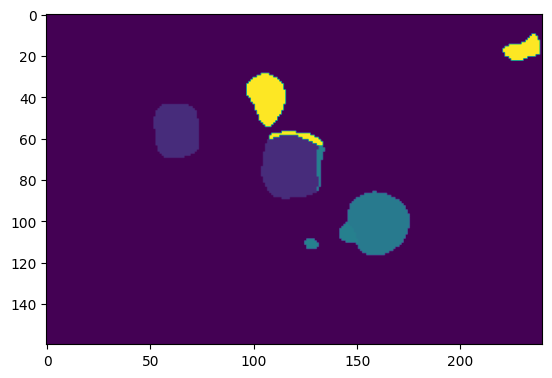

  1%|          | 14/2750 [00:05<17:14,  2.65it/s]

torch.Size([1, 3, 160, 240]) torch.Size([160, 240])


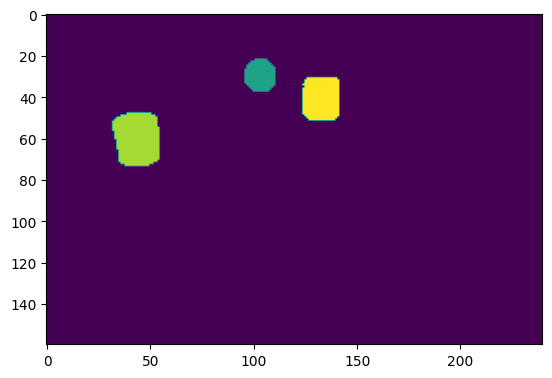

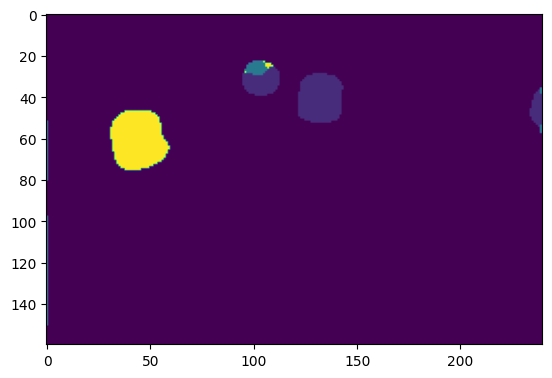

  1%|          | 15/2750 [00:05<17:10,  2.65it/s]

torch.Size([1, 3, 160, 240]) torch.Size([160, 240])


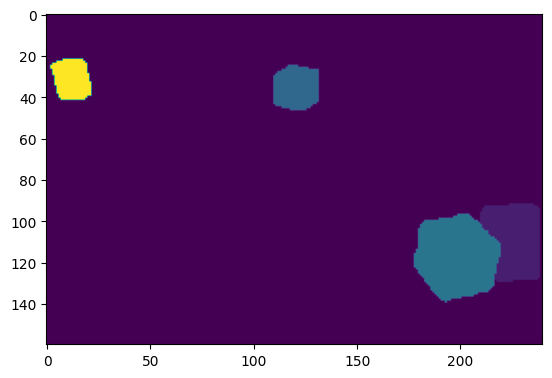

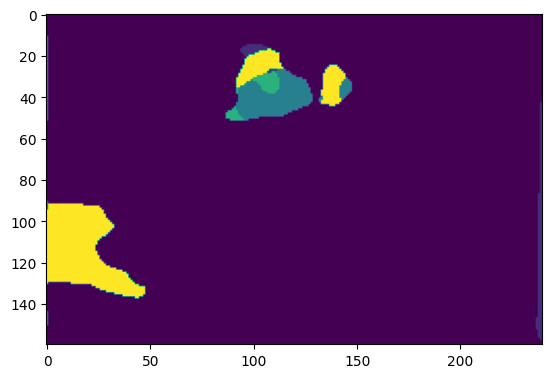

  1%|          | 16/2750 [00:06<17:12,  2.65it/s]

torch.Size([1, 3, 160, 240]) torch.Size([160, 240])


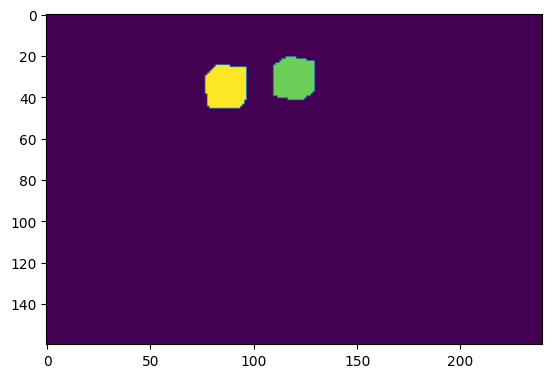

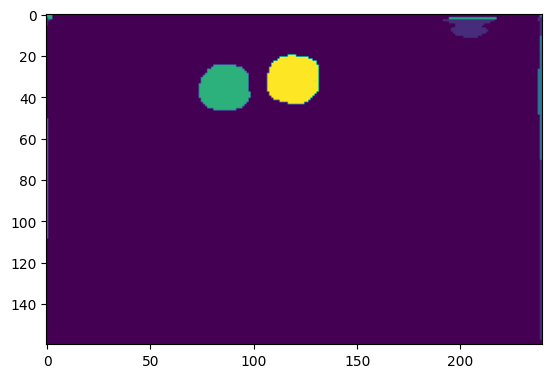

  1%|          | 17/2750 [00:06<17:05,  2.67it/s]

torch.Size([1, 3, 160, 240]) torch.Size([160, 240])


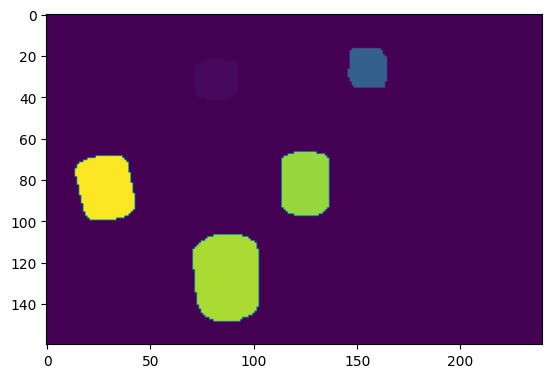

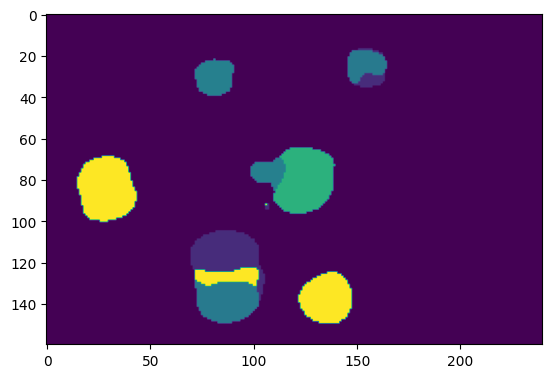

  1%|          | 18/2750 [00:06<17:05,  2.66it/s]

torch.Size([1, 3, 160, 240]) torch.Size([160, 240])


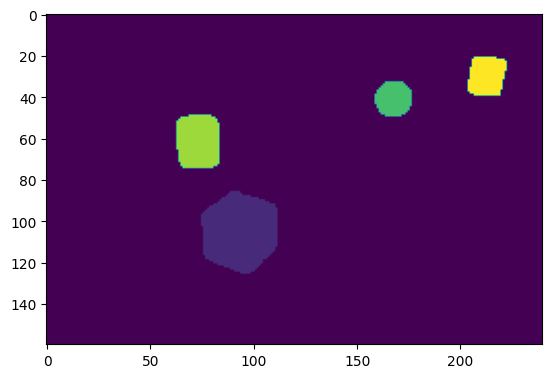

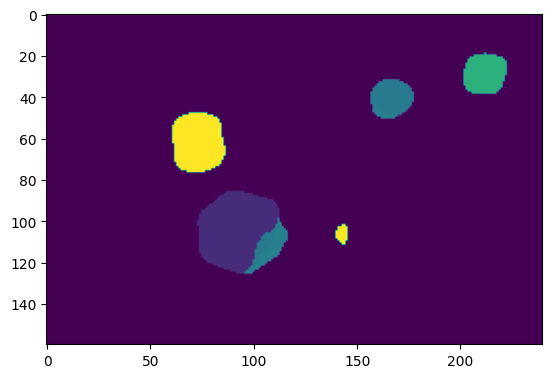

  1%|          | 19/2750 [00:07<17:08,  2.65it/s]

torch.Size([1, 3, 160, 240]) torch.Size([160, 240])


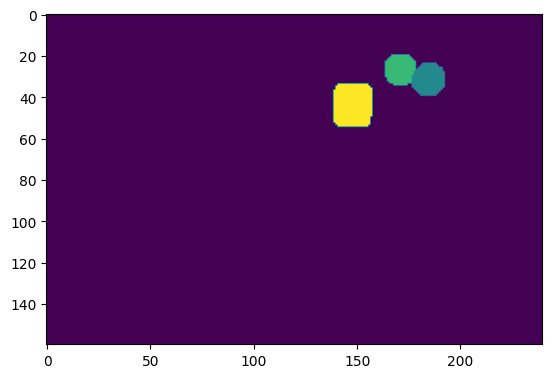

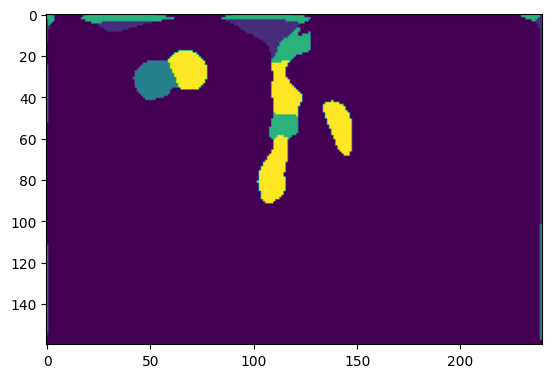

  1%|          | 20/2750 [00:07<19:46,  2.30it/s]

torch.Size([1, 3, 160, 240]) torch.Size([160, 240])


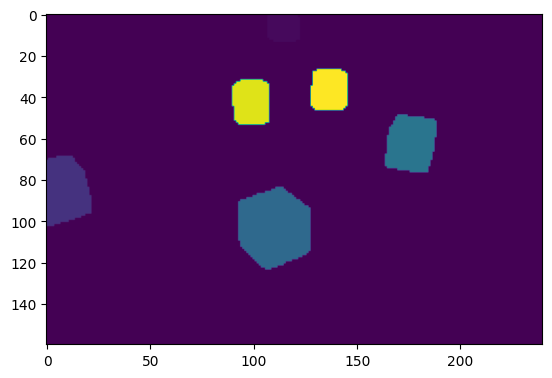

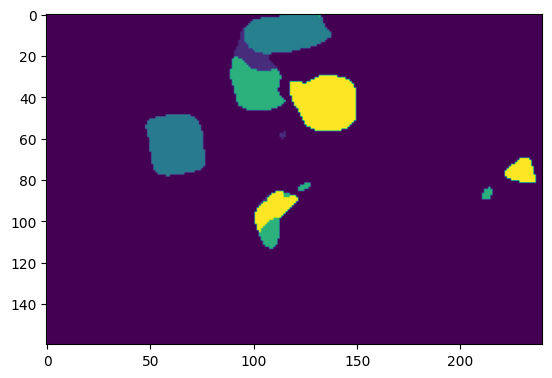

  1%|          | 20/2750 [00:08<18:41,  2.43it/s]


In [14]:
pbar = tqdm(val_dataloader)

for j,batch in enumerate(pbar):
    img = batch[0][0].unsqueeze(0)
    mask = batch[1][0]
    print(img.shape,mask.shape)
    inp = img.to(device)
    p2d = (8, 8)
    new_inp = torch.nn.functional.pad(inp, p2d, "constant", 0)
    mask_pred = model(new_inp)
    mask_pred = mask_pred[:,:,:,8:mask_pred.shape[3]-8]
    plt.imshow(mask.cpu())
    plt.show()
    plt.imshow(torch.argmax(mask_pred[0].cpu(), dim=0))
    plt.show()
    
#     print("loss: ",criterion(img,mask.unsqueeze(0)))
    
    
    if(j == 20):
        break

In [12]:
with torch.no_grad():
    pbar = tqdm(val_dataloader)
    
    for batch in pbar:

        data,target = batch

        data = data.to(device)
        target = target.to(device)

        p2d = (8, 8)
        data = torch.nn.functional.pad(data, p2d, "constant", 0)

        output = model(data)
        output = output[:,:,:,8:output.shape[3]-8]
        target = target.type(torch.LongTensor).to(device)

        loss = criterion(output,target)

        pbar.set_postfix({'batch_validation_loss': loss.item()})

 20%|█▉        | 547/2750 [00:42<02:52, 12.75it/s, batch_validation_loss=3.51]


KeyboardInterrupt: 